In [1]:
import json
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from pycocotools import mask
import itertools
import scipy.io
import skimage.draw
import skimage.measure

In [3]:
def sort_by_mask_area(masks):
    return sorted(masks, reverse=True, key=mask.area)

def overlapping_percentage(mask1, mask2):
    areas = min(mask.area([mask1, mask2]))
    if areas == 0:
        return 0
    percentage = mask.area(mask.merge([mask1, mask2], intersect=True))/areas
    return percentage 
    
# only assess the top 'process_limit' number of largest masks.
def remove_overlapping_small_objects(masks, threshold=0.9, process_limit = 1000):
    if len(masks) == 0:
        return []
    deleted_index = []
    sorted_masks = sort_by_mask_area(masks)
    for i, current_mask in enumerate(sorted_masks):
        if i in deleted_index:
            continue
        if i > process_limit:
            break
        for j in range(i+1, len(sorted_masks)):
            if j in deleted_index:
                continue
            test_mask = sorted_masks[j]
            overlapping = overlapping_percentage(current_mask, test_mask)
            if overlapping > threshold:
                print(overlapping)
                deleted_index.append(j)
    return [m for i, m in enumerate(sorted_masks) if i not in deleted_index]

def remove_multi_part_masks(masks, remove_all = True):
    ret = []
    if not len(masks):
        return ret
    
    decoded_masks = mask.decode(masks)
    for i in range(decoded_masks.shape[-1]):
        decoded_mask = decoded_masks[:, :, i]
        _, c, _ = cv2.findContours(decoded_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(c) > 1 and remove_all:
            continue
        elif len(c) > 1:
            sorted_contours = sorted(c, reverse=True, key=cv2.contourArea)
            canvas = np.zeros(decoded_masks.shape)
            reshaped = c[0].reshape(-1,2)
            x = reshaped[:,0]
            y = reshaped[:,1]
            rr,cc = skimage.draw.polygon(y, x)
            canvas[rr, cc] = 1
            # print (reshaped)
            new_mask = mask.encode(np.asfortranarray(canvas.astype(np.uint8)))[0]
            try:
                new_mask['is'] = masks[i]['is']
            except Exception as e:
                print (e)
            ret.append(new_mask)
        else:
            ret.append(masks[i])
    return ret
def break_up_masks(masks):
    ret = []
    if not len(masks):
        return ret
    
    decoded_masks = mask.decode(masks)
    for i in range(decoded_masks.shape[-1]):
        decoded_mask = decoded_masks[:, :, i]
        _, c, _ = cv2.findContours(decoded_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(c) == 1:
            ret.append(masks[i])
        else:
            for contour in c:
                canvas = np.zeros(decoded_masks.shape)
                reshaped = contour.reshape(-1,2)
                x = reshaped[:,0]
                y = reshaped[:,1]
                rr,cc = skimage.draw.polygon(y, x)
                canvas[rr, cc] = 1
                new_mask = mask.encode(np.asfortranarray(canvas.astype(np.uint8)))[0]
                try:
                    new_mask['is'] = masks[i]['is']
                except Exception as e:
                    print (e)
                ret.append(new_mask)
    return ret
    
def remove_overlapping_cross_classes(multiclass_masks, threshold = 0.9, process_limit = 1000, break_parts = False, remove_multi_part = False, remove_all = True):
    
    #assign attribute for classification
    for i, masks_of_one_class in enumerate(multiclass_masks):
        for mask in masks_of_one_class:
            mask['is'] = i
        
    # flatten all masks in one array
    combined_masks = []
    [combined_masks.extend(masks_of_one_class) for masks_of_one_class in multiclass_masks]
    if break_parts:
        combined_masks = break_up_masks(combined_masks)
    processed_masks = remove_overlapping_small_objects(combined_masks, threshold, process_limit)
    if remove_multi_part:
        processed_masks = remove_multi_part_masks(processed_masks, remove_all)

    ret =  [];
    for i in range(len(multiclass_masks)):
        ret.append([mask for mask in processed_masks if mask['is'] == i])
    return ret

In [ ]:
# generate filtered mask;
counter = 0
with open('infer_result' ,'rb') as input_file, open('infer_result_remove_overlapping', 'wb') as output_file:
    try:
        while True:
            obj = pickle.load(input_file)
            m = json.loads(obj['m'])
            segms = m['cls_segms']
            if not segms:
                # just write it back as is
                pickle.dump(obj, output_file)
                continue
            c_alpha = len(segms[1])
            c_beta = len(segms[2])
            m['cls_segms'] = processed = remove_overlapping_cross_classes(segms)
            reduced_alpha = c_alpha - len(processed[1])
            reduced_beta =  c_beta - len(processed[2])
            if reduced_alpha or reduced_beta:
                print("Alpha count reduced {}, beta count reduced {}".format(reduced_alpha , reduced_beta))
            
            if counter % 100 == 0:
                print("processed {} objects".format(counter))
            obj['m'] = json.dumps(m)
            pickle.dump(obj, output_file)
            counter +=1
    except Exception as e:
        raise e

In [30]:
import pickle
import os
import json
from pycocotools import mask
import skimage.io as io
import cv2
import skimage.color as color
import skimage.measure as measure
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [15, 15]



# check masks
counter = 0
with open('infer_result' ,'rb') as input_file:
    #[pickle.load(input_file) for _ in range(33455)]
    while True:
        obj = pickle.load(input_file)
        f = obj['f']
        if f == '1526509546842.png':
            break
    try:
        while True:
            m = json.loads(obj['m'])
            segms = m['cls_segms']
            if not segms:
                # just write it back as is
                continue
            c_alpha = len(segms[1])
            c_beta = len(segms[2])
            m['cls_segms'] = processed = remove_overlapping_cross_classes(segms, break_parts=True, threshold=0.7)
            reduced_alpha = c_alpha - len(processed[1])
            reduced_beta =  c_beta - len(processed[2])
            if reduced_alpha or reduced_beta:
                print("Alpha count reduced {}, beta count reduced {}".format(reduced_alpha , reduced_beta))
            
            original_d_a = mask.decode(segms[1])
            processed_d_a = mask.decode(processed[1])
            original_d_b = mask.decode(segms[2])
            processed_d_b = mask.decode(processed[2])
            #print(len(original_d_a))
            I = np.zeros((600,800,3)).astype(np.uint8)
            alpha=0.2
            
            cur = original_d_a
            for i in range(cur.shape[-1]):
                colored_mask = color.grey2rgb(cur[..., i]) * [255,0,0]
                I = cv2.addWeighted(I, 1, colored_mask.astype(np.uint8), 1-alpha, 0)
            
            cur = original_d_b
            for i in range(cur.shape[-1]):
                colored_mask = color.grey2rgb(cur[..., i]) * [0,255,0]
                I = cv2.addWeighted(I, 1, colored_mask.astype(np.uint8), 1-alpha, 0)
            
            I_origin = I.copy()
            cur = processed_d_a
            for i in range(cur.shape[-1]):
                #colored_mask = color.grey2rgb(cur[..., i]) * [255,255,255]
                #I = cv2.addWeighted(I, 1, colored_mask.astype(np.uint8), 1-alpha, 0)
                _, contours, h = cv2.findContours(cur[..., i].copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                I = cv2.drawContours(I, contours, -1, (0,0,255), 2)
            
            cur = processed_d_b
            for i in range(cur.shape[-1]):
                #colored_mask = color.grey2rgb(cur[..., i]) * [255,255,255]
                #I = cv2.addWeighted(I, 1, colored_mask.astype(np.uint8), 1-alpha, 0)
                _, contours, h = cv2.findContours(cur[..., i].copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                I = cv2.drawContours(I, contours, -1, (0,0,255), 2)
                
            
            break
            
            
    except Exception as e:
        raise e

1.0
0.8970718722271517
0.8980988593155893
0.9552772808586762
0.7150214592274678
0.9032258064516129
Alpha count reduced 0, beta count reduced -9


In [26]:
f

'1526498470170.png'

In [33]:
skimage.io.imsave(f, I)

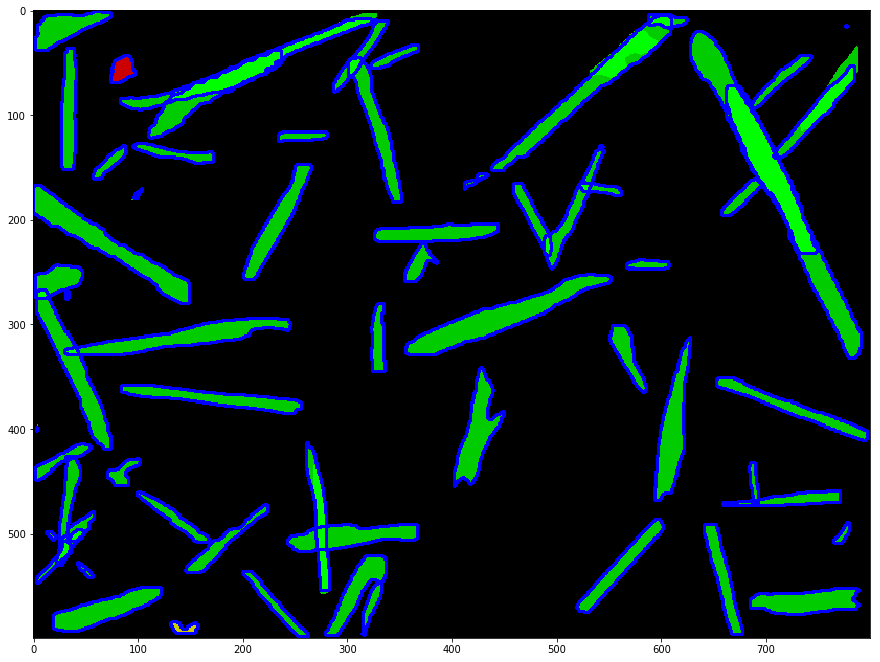

In [32]:
plt.imshow(I)

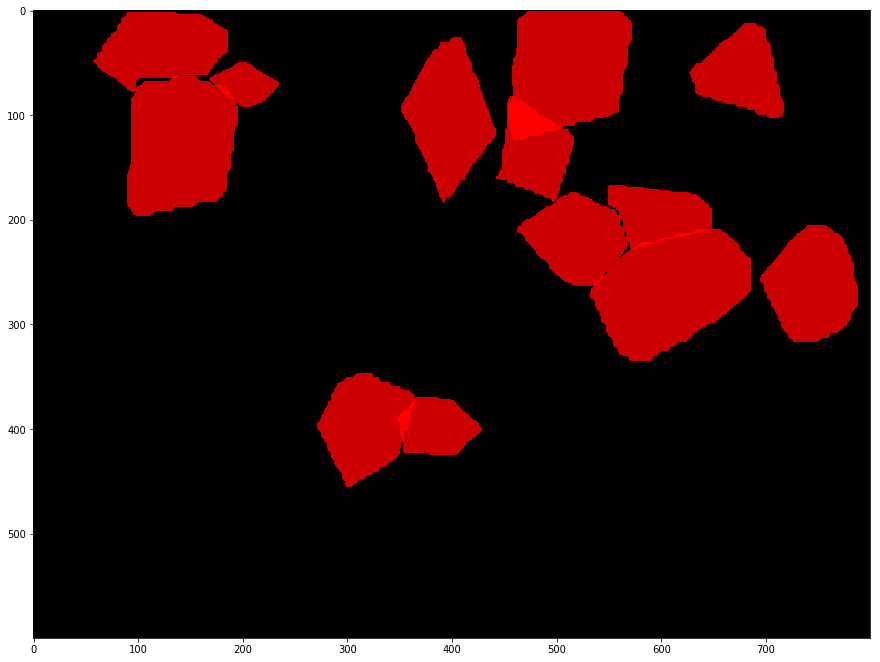

In [16]:
plt.imshow(I_origin)

In [11]:
# count change:`
window_size = 2*60 # 1min

alpha_count = []
beta_count = []
time = []
with open("infer_result_sorted" ,'rb') as input_file:
    try:
        while True:
            alpha_num = 0
            beta_num = 0
            counter = 0
            time_list = []
            while True:
                obj = pickle.load(input_file)
                t = obj['timestamp']
                time_list.append(t)
                #m = json.loads(obj['m'])['cls_segms']
                m = obj['m']['cls_segms']
                if not m:
                    continue
                m_alpha = len(m[1])
                m_beta = len(m[2])
                alpha_num += m_alpha
                beta_num += m_beta
                counter += 1
                if time_list[-1] - time_list[0] >= window_size * 1000:
                    break
            alpha_count.append(alpha_num/counter)
            beta_count.append(beta_num/counter)
            time.append(np.average(time_list))
    except Exception as e:
        raise e

EOFError: Ran out of input

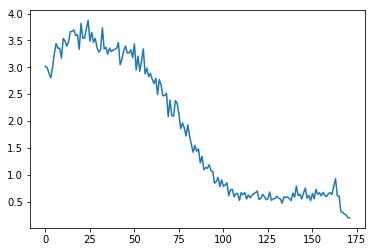

In [13]:
plt.plot(alpha_count)

In [14]:
scipy.io.savemat("counts", {"alpha_count": np.array(alpha_count), "beta_count": np.array(beta_count), "time": np.array(time)})

In [16]:
# generate area data
window_size = 2*60 # 1min

alpha_dist = []
beta_dist = []
counter_list = []
time = []
with open('infer_result_sorted' ,'rb') as input_file:
    try:
        while True:
            alpha_list = []
            beta_list = []
            counter = 0
            
            time_list = []
            while True:
                obj = pickle.load(input_file)
                t = obj['timestamp']
                time_list.append(t)
                #m = json.loads(obj['m'])['cls_segms']
                clssegms = obj['m']['cls_segms']
                if not clssegms:
                    continue
                alpha_list.extend(mask.area(clssegms[1]).tolist())
                beta_list.extend(mask.area(clssegms[2]).tolist())

                counter += 1
                if time_list[-1] - time_list[0] >= window_size * 1000:
                    break
            alpha_dist.append(alpha_list)
            beta_dist.append(beta_list)
            counter_list.append(counter)
            time.append(np.average(time_list))
    except Exception as e:
        raise (e)

EOFError: Ran out of input

In [17]:
scipy.io.savemat("areas", {"alpha_dist": alpha_dist, "beta_dist": beta_dist, "time": time, "counter_list": counter_list})

In [ ]:
len(alpha_dist)

In [ ]:
# generate ellipse data
window_size = 2*60 # 1min

alpha_ellipse = []
beta_ellipse = []
time = []
with open('ellipse.p' ,'rb') as input_file:
    try:
        while True:
            alpha_list = []
            beta_list = []
            time_list = []
            for i in range(window_size):
                obj = pickle.load(input_file)
                t = obj['timestamp']
                time_list.append(t)
                alpha_list.extend(obj['alpha_ellipses'])
                beta_list.extend(obj['beta_ellipses'])
            alpha_ellipse.append(alpha_list)
            beta_ellipse.append(beta_list)
            time.append(np.average(time_list))
    except Exception as e:
        print(e)

In [ ]:
scipy.io.savemat("ellipses", {"alpha_ellipse": alpha_ellipse, "beta_ellipse": beta_ellipse, "time": time})

In [ ]:
n = np.array([[[1,2]],[[3,4]]])

In [ ]:
n.reshape(-1,2).shape